In [11]:
import spacy
import re
import pandas as pd

nlp = spacy.load("en_core_web_sm")

def clean_resume(text):
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)  # keep alphanumerics
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

In [12]:
import spacy
nlp = spacy.load("en_core_web_sm")
doc = nlp("This is a test sentence.")
print([token.text for token in doc])

['This', 'is', 'a', 'test', 'sentence', '.']


In [13]:
job_skills = ["python", "machine learning", "nlp", "flask", "sql"]

def extract_skills(text):
    text = text.lower()
    return [skill for skill in job_skills if skill in text]

In [14]:
def score_resume(resume_text, job_skills):
    resume_skills = extract_skills(resume_text)
    score = len(resume_skills) / len(job_skills)
    missing = set(job_skills) - set(resume_skills)
    return score, resume_skills, missing

In [15]:
resumes = pd.read_csv("../data/sample_resumes.csv")

results = []
for i, row in resumes.iterrows():
    score, found, missing = score_resume(row["resume_text"], job_skills)
    results.append({
        "candidate": row["name"],
        "score": score,
        "skills_found": found,
        "skills_missing": list(missing)
    })

ranked = pd.DataFrame(results).sort_values(by="score", ascending=False)
print(ranked)

   candidate  score                                 skills_found  \
0      Alice    1.0  [python, machine learning, nlp, flask, sql]   
3      Diana    0.6              [python, machine learning, nlp]   
1        Bob    0.4                   [python, machine learning]   
2    Charlie    0.4                                [python, sql]   
5     Fatima    0.4                                [python, nlp]   
6     George    0.4                                [python, sql]   
10     Kevin    0.4                                [python, sql]   
13      Nina    0.4                                [python, sql]   
9      Julia    0.2                                     [python]   
8       Ivan    0.2                                     [python]   
7     Hannah    0.2                           [machine learning]   
14     Oscar    0.2                                        [nlp]   
11     Laura    0.2                                        [nlp]   
4      Ethan    0.0                             

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Combine resumes + job description
documents = resumes["resume_text"].tolist()
documents.append("Python, machine learning, NLP, Flask, SQL")  # job description

# Vectorize
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(documents)

# Last vector is job description
job_vec = tfidf_matrix[-1]
resume_vecs = tfidf_matrix[:-1]

# Compute similarity
scores = cosine_similarity(resume_vecs, job_vec)
resumes["similarity_score"] = scores.flatten()

# Rank candidates
ranked = resumes.sort_values(by="similarity_score", ascending=False)
print(ranked[["name", "similarity_score"]])

       name  similarity_score
0     Alice          0.488998
3     Diana          0.357760
1       Bob          0.231829
2   Charlie          0.181806
7    Hannah          0.157979
14    Oscar          0.151398
6    George          0.134676
13     Nina          0.120622
10    Kevin          0.118904
5    Fatima          0.117489
11    Laura          0.080938
8      Ivan          0.044268
9     Julia          0.042954
4     Ethan          0.000000
12  Michael          0.000000


In [17]:
resumes["final_score"] = 0.7*resumes["similarity_score"] + 0.3*resumes["skill_overlap_score"]

In [18]:
job_skills = ["python", "machine learning", "nlp", "flask", "sql"]

In [19]:
def skill_overlap(resume_text, job_skills):
    resume_text = resume_text.lower()
    found = [skill for skill in job_skills if skill in resume_text]
    score = len(found) / len(job_skills)
    return score

In [20]:
resumes["skill_overlap_score"] = resumes["resume_text"].apply(lambda x: skill_overlap(x, job_skills))

In [21]:
resumes["final_score"] = 0.7*resumes["similarity_score"] + 0.3*resumes["skill_overlap_score"]
ranked = resumes.sort_values(by="final_score", ascending=False)
print(ranked[["name", "similarity_score", "skill_overlap_score", "final_score"]])

       name  similarity_score  skill_overlap_score  final_score
0     Alice          0.488998                  1.0     0.642299
3     Diana          0.357760                  0.6     0.430432
1       Bob          0.231829                  0.4     0.282280
2   Charlie          0.181806                  0.4     0.247264
6    George          0.134676                  0.4     0.214273
13     Nina          0.120622                  0.4     0.204435
10    Kevin          0.118904                  0.4     0.203233
5    Fatima          0.117489                  0.4     0.202242
7    Hannah          0.157979                  0.2     0.170585
14    Oscar          0.151398                  0.2     0.165978
11    Laura          0.080938                  0.2     0.116656
8      Ivan          0.044268                  0.2     0.090987
9     Julia          0.042954                  0.2     0.090068
4     Ethan          0.000000                  0.0     0.000000
12  Michael          0.000000           

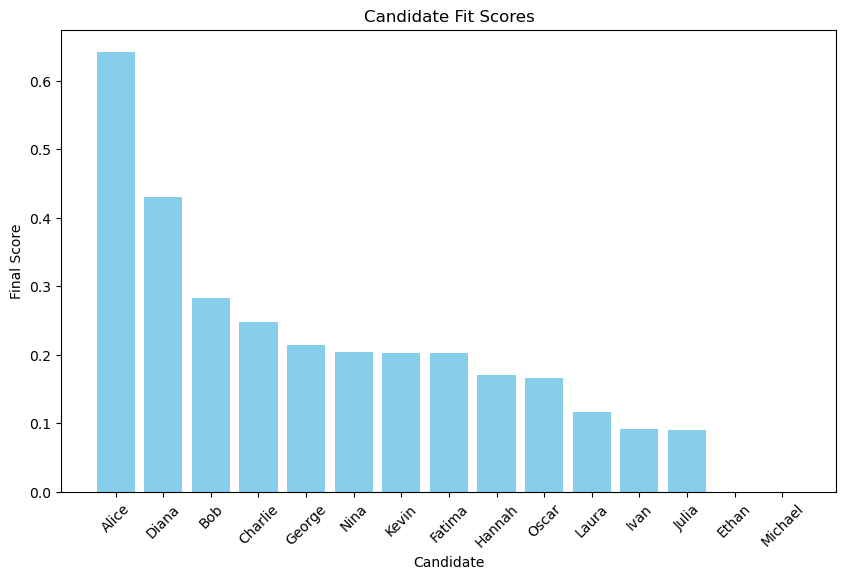

In [22]:
import matplotlib.pyplot as plt

ranked = resumes.sort_values(by="final_score", ascending=False)

plt.figure(figsize=(10,6))
plt.bar(ranked["name"], ranked["final_score"], color="skyblue")
plt.title("Candidate Fit Scores")
plt.xlabel("Candidate")
plt.ylabel("Final Score")
plt.xticks(rotation=45)
plt.show()

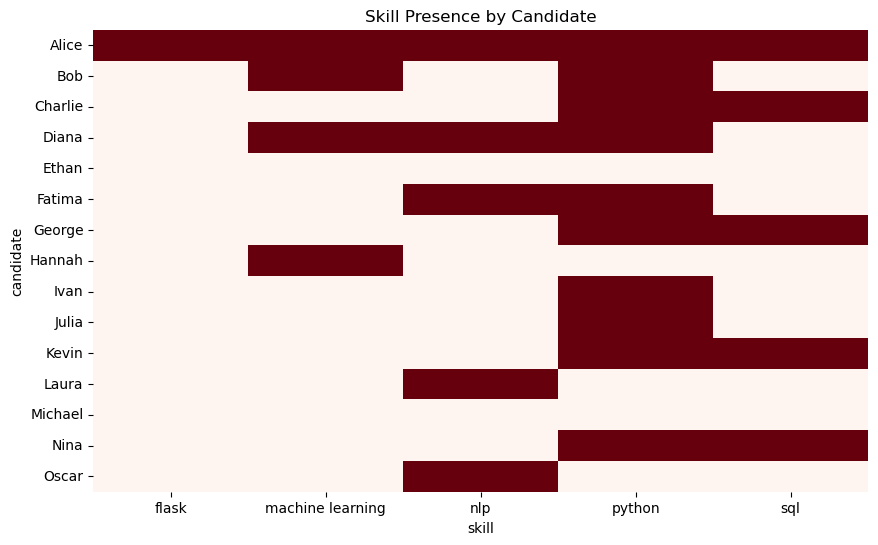

In [26]:
import seaborn as sns

# Create a dataframe of skill gaps
gap_data = []
for i, row in ranked.iterrows():
    for skill in job_skills:
        gap_data.append({
            "candidate": row["name"],
            "skill": skill,
            "has_skill": skill in row["resume_text"].lower()
        })

gap_df = pd.DataFrame(gap_data)
pivot_df = gap_df.pivot(index="candidate", columns="skill", values="has_skill")

plt.figure(figsize=(10,6))
sns.heatmap(pivot_df, cmap="Reds", cbar=False)
plt.title("Skill Presence by Candidate")
plt.show()